# Simple electricity market example

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

In [1]:
fuel_cost = dict(
    coal=8,
    gas=100,
    oil=48,
)

In [2]:
efficiency = dict(
    coal=0.33,
    gas=0.58,
    oil=0.35,
)

In [3]:
# t/MWh thermal
emissions = dict(
    coal=0.34,
    gas=0.2,
    oil=0.26,
    hydro=0,
    wind=0,
)

In [4]:
power_plants = {
    "SA": {"coal": 35000, "wind": 3000, "gas": 8000, "oil": 2000},
    "MZ": {"hydro": 1200},
}

In [5]:
loads = {
    "SA": 42000,
    "MZ": 650,
}

In [6]:
import pypsa
n = pypsa.Network()

In [7]:
n.add("Bus", "SA", y=-30.5, x=25, v_nom=400, carrier="AC")
n.add("Bus", "MZ", y=-18.5, x=35.5, v_nom=400, carrier="AC")

Index(['MZ'], dtype='object')

In [8]:
n.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
SA,400.0,,25.0,-30.5,AC,,1.0,0.0,inf,PQ,,
MZ,400.0,,35.5,-18.5,AC,,1.0,0.0,inf,PQ,,


In [9]:
n.madd(
    "Carrier",
    ["coal", "gas", "oil", "hydro", "wind"],
    co2_emissions=emissions,
    nice_name=["Coal", "Gas", "Oil", "Hydro", "Onshore Wind"],
    color=["grey", "indianred", "black", "aquamarine", "dodgerblue"],
)

C:\Users\MS\AppData\Local\Temp\ipykernel_7600\2692078413.py:1: DeprecatedWarning:

madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.



Index(['coal', 'gas', 'oil', 'hydro', 'wind'], dtype='object')

In [10]:
n.add(
    "Generator",
    "MZ hydro",
    bus="MZ",
    carrier="hydro",
    p_nom=1200,  # MW
    marginal_cost=0,  # default
)

Index(['MZ hydro'], dtype='object')

In [11]:
for tech, p_nom in power_plants["SA"].items():
    n.add(
        "Generator",
        f"SA {tech}",
        bus= "SA",
        carrier=tech,
        efficiency = efficiency.get(tech,1),
        p_nom = p_nom,
        marginal_cost=fuel_cost.get(tech, 0) / efficiency.get(tech, 1),
    )

In [12]:
n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MZ hydro,MZ,PQ,,1200.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA coal,SA,PQ,,35000.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA wind,SA,PQ,,3000.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA gas,SA,PQ,,8000.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA oil,SA,PQ,,2000.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [13]:
n.add(
    "Load",
    "SA electricity demand",
    bus="SA",
    p_set=loads["SA"],
    carrier="electricity",
)

Index(['SA electricity demand'], dtype='object')

In [14]:
n.add(
    "Load",
    "MZ electricity demand",
    bus="MZ",
    p_set=loads["MZ"],
    carrier="electricity",
)

Index(['MZ electricity demand'], dtype='object')

In [15]:
n.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
SA electricity demand,SA,electricity,,42000.0,0.0,-1.0,True
MZ electricity demand,MZ,electricity,,650.0,0.0,-1.0,True


In [16]:
n.add(
    "Line",
    "SA-MZ",
    bus0="SA",
    bus1="MZ",
    s_nom=500,
    x=1, # Impedance
    r=1, # Reactance
)

Index(['SA-MZ'], dtype='object')

C:\Users\MS\anaconda3\envs\esm-ws-24-25\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x1bd5faea1b0>,
 <matplotlib.collections.LineCollection at 0x1bd5fb10c80>)

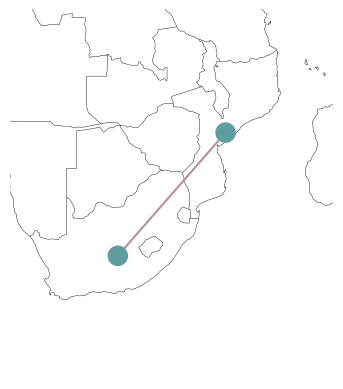

In [17]:
n.plot(bus_sizes = 1, margin = 1)

In [18]:
n.optimize(solver_name="highs")

Index(['SA electricity demand', 'MZ electricity demand'], dtype='object', name='Load')
Index(['SA-MZ'], dtype='object', name='Line')
Index(['SA', 'MZ'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 14 duals
Objective: 1.38e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [19]:
n.generators_t.p

Generator,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,1150.0,35000.0,3000.0,1500.0,2000.0


In [20]:
n.lines_t.p0 # In one direction

Line,SA-MZ
snapshot,
now,-500.0


In [21]:
n.lines_t.p1 # In one direction

Line,SA-MZ
snapshot,
now,500.0


In [22]:
n.buses_t.marginal_price

Bus,SA,MZ
snapshot,,
now,172.413793,-0.0


C:\Users\MS\anaconda3\envs\esm-ws-24-25\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x1bd6310a1b0>,
 <matplotlib.collections.LineCollection at 0x1bd63108c80>)

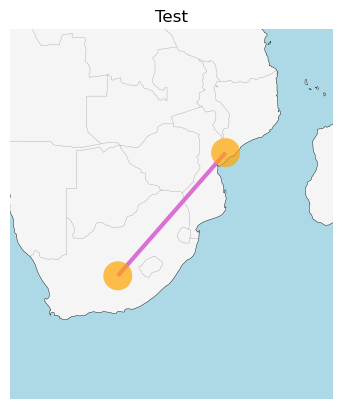

In [23]:
n.plot(
    margin=1,
    bus_sizes=2,
    bus_colors="orange",
    bus_alpha = 0.7,
    color_geomap=True,
    line_colors="orchid",
    line_widths=3,
    title="Test",
)

In [24]:
s = n.generators_t.p.loc["now"].groupby([n.generators.bus, n.generators.carrier]).sum()

C:\Users\MS\anaconda3\envs\esm-ws-24-25\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



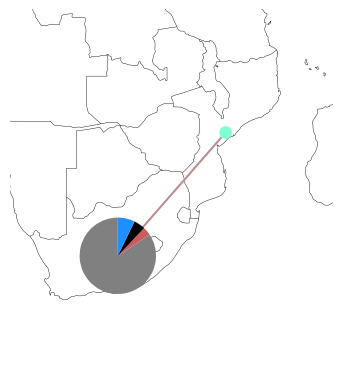

In [25]:
n.plot(margin=1, bus_sizes=s / 3000);

In [26]:
n.lines.loc["SA-MZ", "s_nom"] = 400

In [27]:
n.optimize(solver_name="highs")

Index(['SA electricity demand', 'MZ electricity demand'], dtype='object', name='Load')
Index(['0'], dtype='object', name='SubNetwork')
Index(['SA-MZ'], dtype='object', name='Line')
Index(['SA', 'MZ'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 14 duals
Objective: 1.40e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [28]:
n.lines_t.p0

Line,SA-MZ
snapshot,
now,-400.0


In [29]:
n.lines_t.p1

Line,SA-MZ
snapshot,
now,400.0


In [30]:
e = (
    n.generators_t.p * n.generators.carrier.map(n.carriers.co2_emissions) / n.generators.efficiency
)
e

Generator,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.0,36060.606061,0.0,551.724138,1485.714286


In [31]:
e.sum().sum()

np.float64(38098.044484251375)

In [32]:
n.add(
    "GlobalConstraint", # Key Element
    "emission_limit", # Just a name
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=e.sum().sum() * 0.9,
)

Index(['emission_limit'], dtype='object')

In [33]:
n.optimize(solver_name = "highs")

Index(['SA electricity demand', 'MZ electricity demand'], dtype='object', name='Load')
Index(['0'], dtype='object', name='SubNetwork')
Index(['SA-MZ'], dtype='object', name='Line')
Index(['SA', 'MZ'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 15 duals
Objective: 2.12e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [34]:
n.global_constraints.loc["emission_limit", "constant"] = 0.85 * e.sum().sum()

In [35]:
n.optimize(solver_name="highs")

Index(['SA electricity demand', 'MZ electricity demand'], dtype='object', name='Load')
Index(['0'], dtype='object', name='SubNetwork')
Index(['SA-MZ'], dtype='object', name='Line')
Index(['SA', 'MZ'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible



('warning', 'infeasible')

In [36]:
n.global_constraints.loc["emission_limit", "constant"] = 0.95 * e.sum().sum()

In [37]:
n.optimize(solver_name="highs")

Index(['SA electricity demand', 'MZ electricity demand'], dtype='object', name='Load')
Index(['0'], dtype='object', name='SubNetwork')
Index(['SA-MZ'], dtype='object', name='Line')
Index(['SA', 'MZ'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 15 duals
Objective: 1.71e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


('ok', 'optimal')

In [38]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
emission_limit,primary_energy,NaN,co2_emissions,<=,36193.14226,-216.158537
